# Gaussian Process Regression for Permafrost Prediction

Here I explore using GPs to predict permafrost thaw depth based on various environmental covariates.

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# general libraries
import glob
import os
import pathlib
import site
import sys
import warnings
# data handling libraries
import geopandas as gpd
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
from tqdm.dask import TqdmCallback as ProgressBarDask
from tqdm.notebook import tqdm as ProgressBar
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# machine learning libraries
import gpytorch
from sklearn import gaussian_process as gp
from sklearn import preprocessing
from sklearn import model_selection 
import torch

# pamir libraries
import pamir_mlpermafrost as pamir

# Loading data

In [16]:
data_X, data_y = pamir.models.data.load_training_data(sel='S180')
X_train, X_test, y_train, y_test = pamir.models.data.train_test_split(data_X, data_y)

In [26]:
device = "cpu"  # mps not enabled for GPyTorch

# 1. Data Preprocessing - CRITICAL for GPs
scaler_X = pamir.models.data.StandardScaler_toTensor(device=device)
scaler_y = pamir.models.data.StandardScaler_toTensor(device=device)

# Scale features
X_train_scaled_tensor = scaler_X.fit_transform(X_train)
X_test_scaled_tensor = scaler_X.transform(X_test)

# Scale target (reshape for sklearn)
y_train_scaled_tensor = scaler_y.fit_transform(y_train).ravel()
y_test_scaled_tensor = scaler_y.transform(y_test).ravel()

In [27]:
model = pamir.models.gp.simple.make_model(X_train_scaled_tensor, y_train_scaled_tensor)

In [28]:
# Debug the model state
print("=== MODEL DEBUG ===")
print(f"Model has likelihood: {hasattr(model, 'likelihood')}")
print(f"Model train_inputs shape: {model.train_inputs[0].shape if model.train_inputs else 'None'}")
print(f"Model train_targets shape: {model.train_targets.shape if model.train_targets is not None else 'None'}")
print(f"Model training mode: {model.training}")
print(f"Model device: {next(model.parameters()).device}")

=== MODEL DEBUG ===
Model has likelihood: True
Model train_inputs shape: torch.Size([4524, 34])
Model train_targets shape: torch.Size([4524])
Model training mode: True
Model device: cpu


In [29]:
model, losses = pamir.models.gp.train.train_mll(
    model, 
    X_train_scaled_tensor, 
    y_train_scaled_tensor,
    n_iters=1000, 
    tolerance=1e-3)

Iter 10/1000 - Loss: 1.250240
Iter 20/1000 - Loss: 1.182062
Iter 20/1000 - Loss: 1.182062
Iter 30/1000 - Loss: 1.086518
Iter 30/1000 - Loss: 1.086518
Iter 40/1000 - Loss: 0.981362
Iter 40/1000 - Loss: 0.981362
Iter 50/1000 - Loss: 0.876598
Iter 50/1000 - Loss: 0.876598
Iter 60/1000 - Loss: 0.783525
Iter 60/1000 - Loss: 0.783525
Iter 70/1000 - Loss: 0.705913
Iter 70/1000 - Loss: 0.705913
Iter 80/1000 - Loss: 0.652939
Iter 80/1000 - Loss: 0.652939
Iter 90/1000 - Loss: 0.606679
Iter 90/1000 - Loss: 0.606679
Iter 100/1000 - Loss: 0.574114
Iter 100/1000 - Loss: 0.574114
Iter 110/1000 - Loss: 0.553746
Iter 110/1000 - Loss: 0.553746
Converged at iteration 113
Converged at iteration 113


In [30]:
scores, y_pred, y_pred_std = pamir.models.gp.inference.eval(
    model, 
    X_test_scaled_tensor, 
    y_test_scaled_tensor, 
    scaler_y
)

Test Set Performance (Original Scale):
MSE: 2.3750
RMSE: 1.5411
MAE: 0.9962
R²: 0.8559
Predicted Std Dev: 2.0429


In [40]:
ds_spatial = xr.open_zarr('../../pamir-CryoGrid/forcing/spatial_variables-710w365s750e400n-100m.zarr/')
ds_spatial = ds_spatial.isel(x=slice(0, 1000), y=slice(0, 1000))

In [41]:
# load inference data
features = data_X.columns.tolist()

X_inference = pamir.models.data.load_inference_data_from_zarr(ds_spatial)
X_inference_tensor_scaled = scaler_X.transform(X_inference[features])

In [36]:
yhat_mu, yhat_sigma = pamir.models.gp.inference.predict(
    model, 
    X_inference_tensor_scaled, 
    scaler_y, 
    inference_batch_size=50_000)

In [42]:
mask = (
    (ds_spatial.surface_index > 0) 
    & 
    (ds_spatial.altitude > 3100)
)

# Problem with this output

We know that temperature does not increase as altitude decreases - here, we observe this very counter-intuitive behaviour.  
To contstrain this, we can use a custom kernel for the parameters where we know the rough behaviour

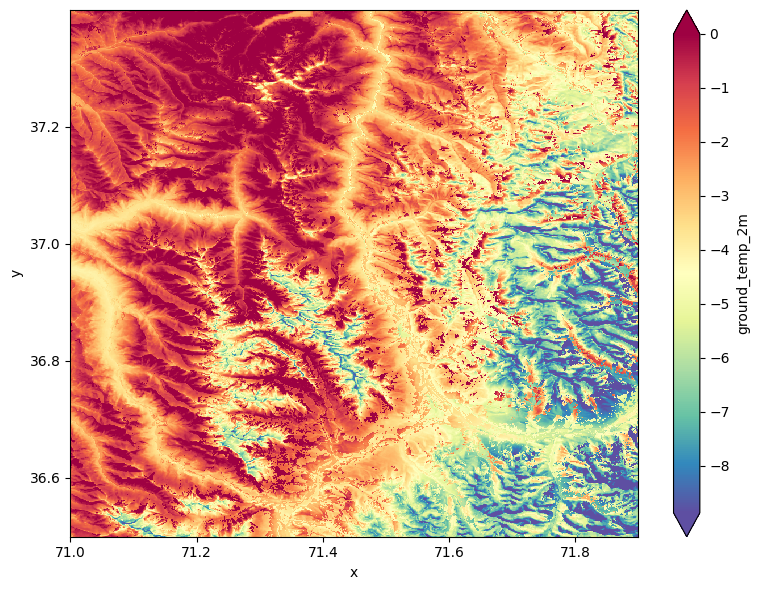

In [43]:
# 6. Compare original vs improved predictions
yhat_da = yhat_mu.set_index(X_inference.index).iloc[:,0].to_xarray()

# Plot comparison
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# Improved predictions
yhat_da.plot.imshow(ax=axes, cmap='Spectral_r', robust=True, vmax=0)

plt.tight_layout()
plt.show()